In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai import *
from fastai.vision import *

## Dataset

In [3]:
# Learn how the untar_data function works
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True)
    Download `url` if doesn't exist to `fname` and un-tgz to folder `dest`



In [4]:
URLs

fastai.datasets.URLs

In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

Dataset is [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds.

In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

['annotations', 'images']

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/newfoundland_29.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_135.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_192.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [12]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

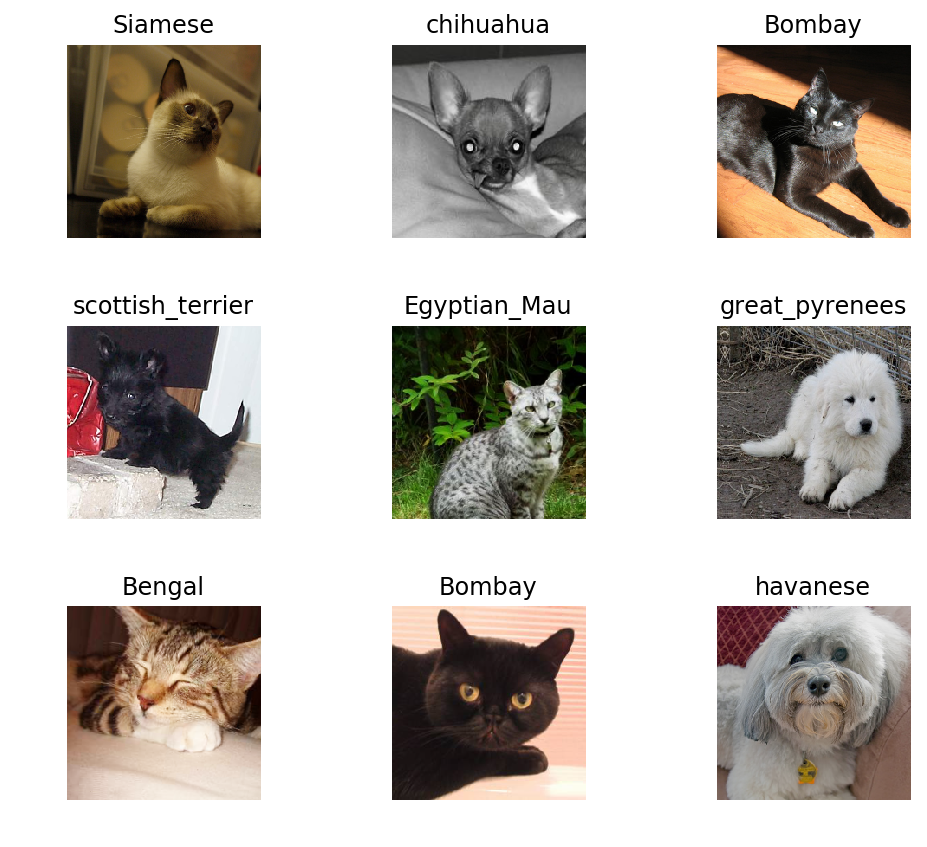

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes), data.c

['pomeranian', 'Maine_Coon', 'newfoundland', 'shiba_inu', 'beagle', 'Bengal', 'British_Shorthair', 'Egyptian_Mau', 'miniature_pinscher', 'Birman', 'english_cocker_spaniel', 'leonberger', 'Abyssinian', 'american_bulldog', 'german_shorthaired', 'Siamese', 'staffordshire_bull_terrier', 'pug', 'american_pit_bull_terrier', 'basset_hound', 'english_setter', 'Russian_Blue', 'saint_bernard', 'chihuahua', 'yorkshire_terrier', 'Ragdoll', 'havanese', 'samoyed', 'keeshond', 'scottish_terrier', 'Persian', 'Sphynx', 'japanese_chin', 'Bombay', 'wheaten_terrier', 'boxer', 'great_pyrenees']


(37, 37)

## Training Round I: ResNet34

In [15]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(4)

Total time: 02:15
epoch  train loss  valid loss  error_rate
1      1.171932    0.294736    0.091151    (00:35)
2      0.515710    0.218706    0.075848    (00:33)
3      0.316936    0.188939    0.059880    (00:33)
4      0.232521    0.182049    0.057219    (00:33)



In [17]:
learn.save('stage-1')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

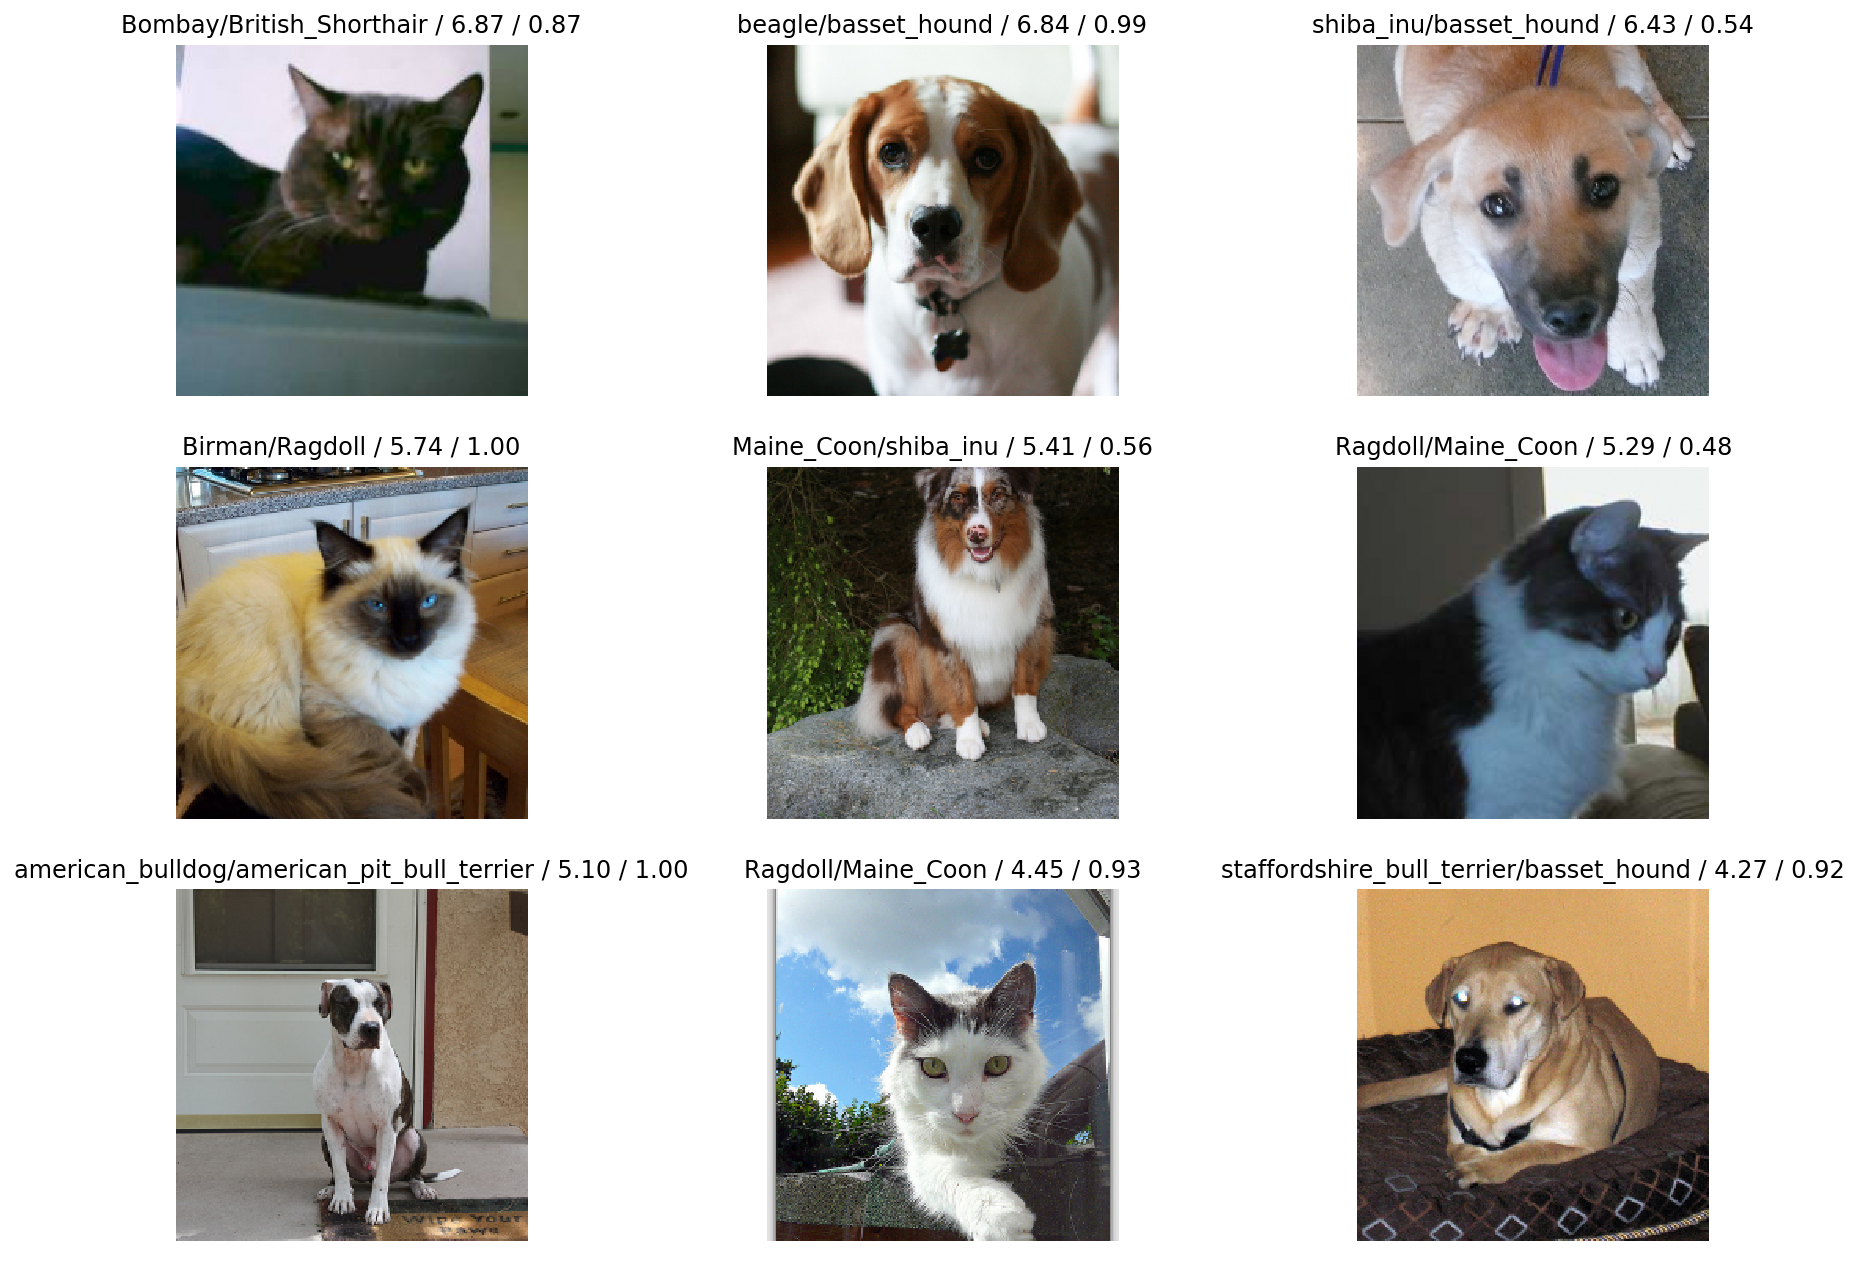

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

#### Results

In [20]:
doc(interp.plot_top_losses)

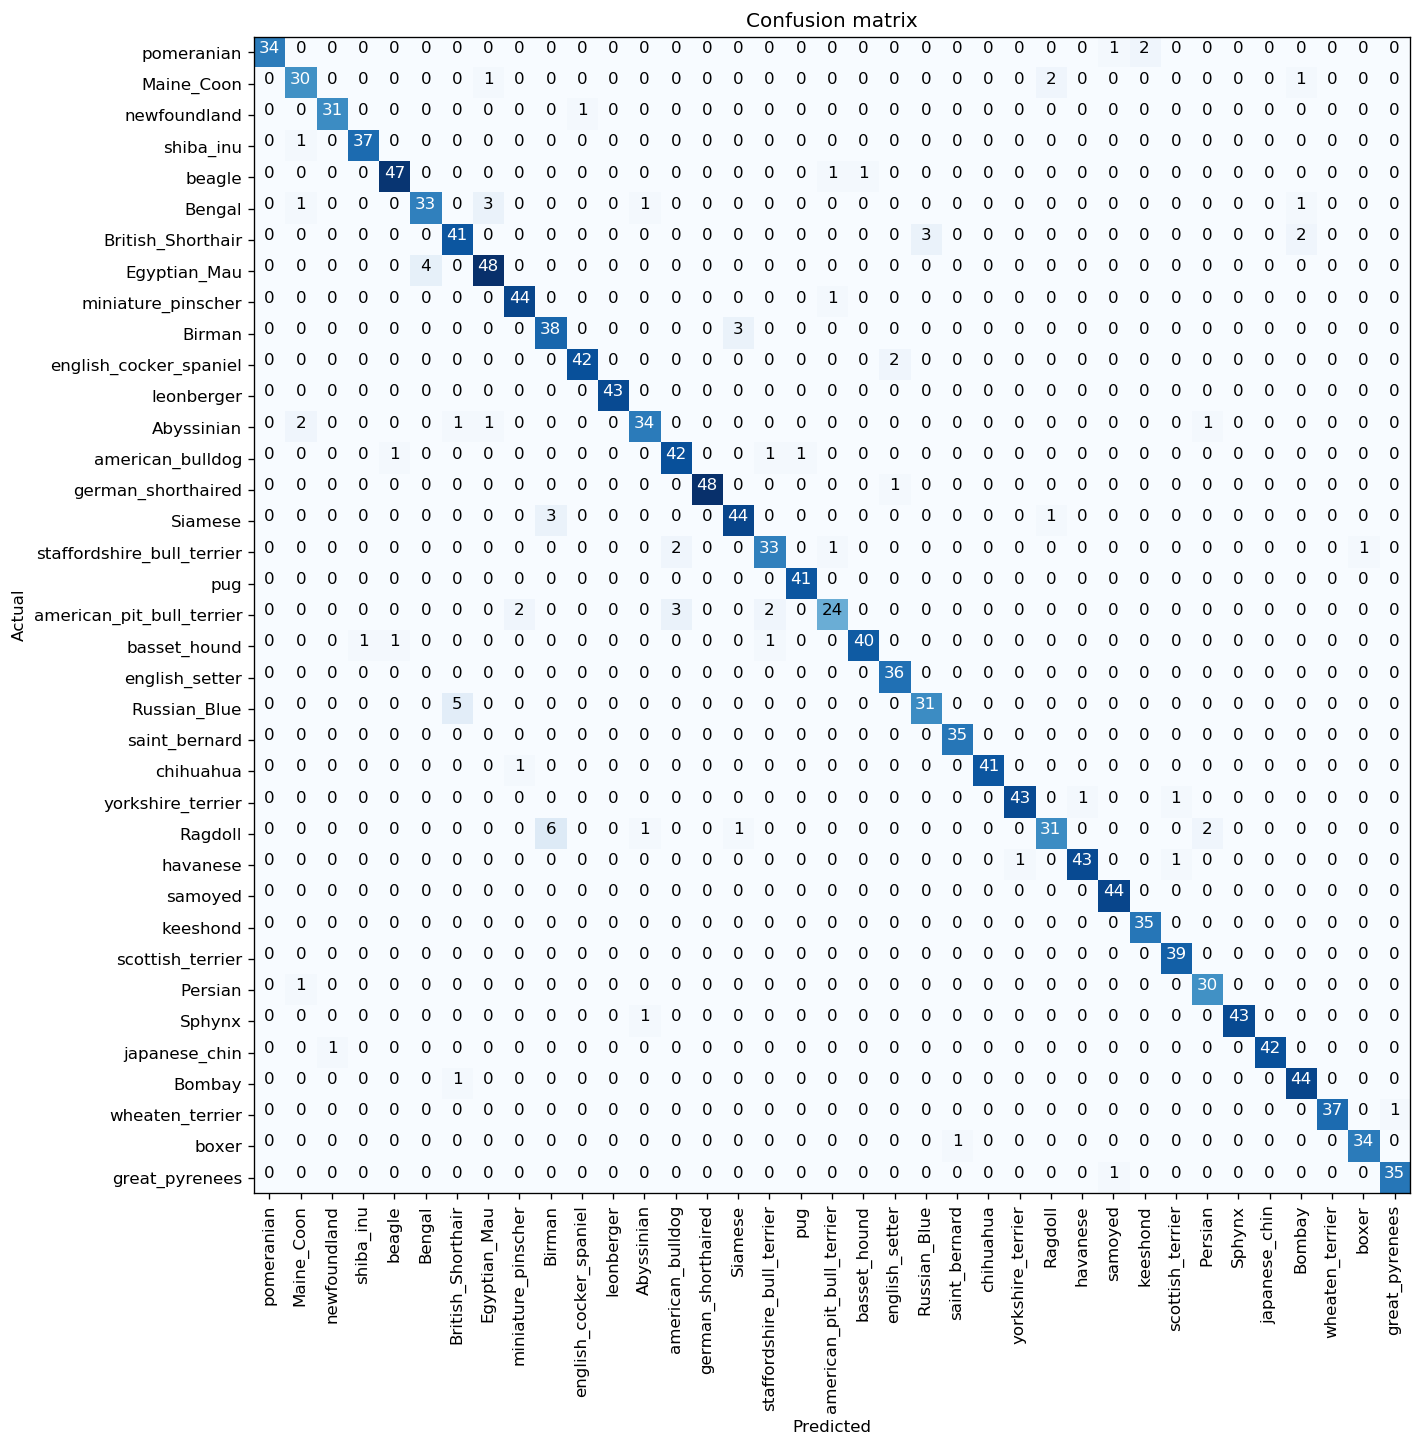

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Birman', 'Siamese', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3)]

#### Unfreeze and fine-tune

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1)

Total time: 00:41
epoch  train loss  valid loss  error_rate
1      1.017503    0.550374    0.168330    (00:41)



In [25]:
learn.load('stage-1')

In [26]:
learn.lr_find()

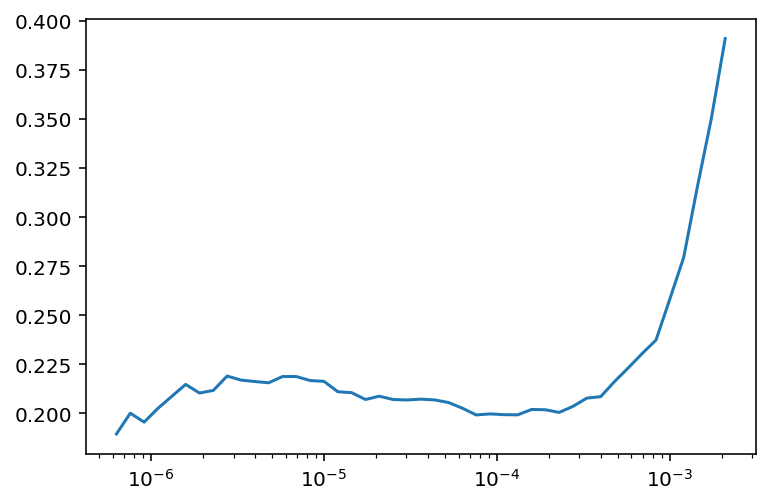

In [27]:
learn.recorder.plot()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:23
epoch  train loss  valid loss  error_rate
1      0.200447    0.180245    0.054558    (00:41)
2      0.186621    0.173450    0.056554    (00:42)



## Training Round II: ResNet50

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=32)

In [12]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [13]:
learn.fit_one_cycle(5)

Total time: 09:14
epoch  train loss  valid loss  error_rate
1      0.523606    0.239018    0.081836    (01:57)
2      0.389033    0.216035    0.077844    (01:48)
3      0.258214    0.209902    0.069860    (01:49)
4      0.167864    0.166866    0.051896    (01:49)
5      0.129428    0.153613    0.047239    (01:49)



In [14]:
learn.save('stage-1-50')

#### Unfreeze and fine-tune

In [15]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

Total time: 02:26
epoch  train loss  valid loss  error_rate
1      0.113129    0.161282    0.048570    (02:26)



Unfreezing doesn't provide substantial improvement to our model's performance. We'll go with the weights saved under 'stage-1-50'.

In [16]:
learn.load('stage-1-50')

#### Results

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

In [18]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 4)]

## Exploring Other Data Formats

In [19]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/jupyter/.fastai/data/mnist_sample')

#### Image data from a folder

In [21]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

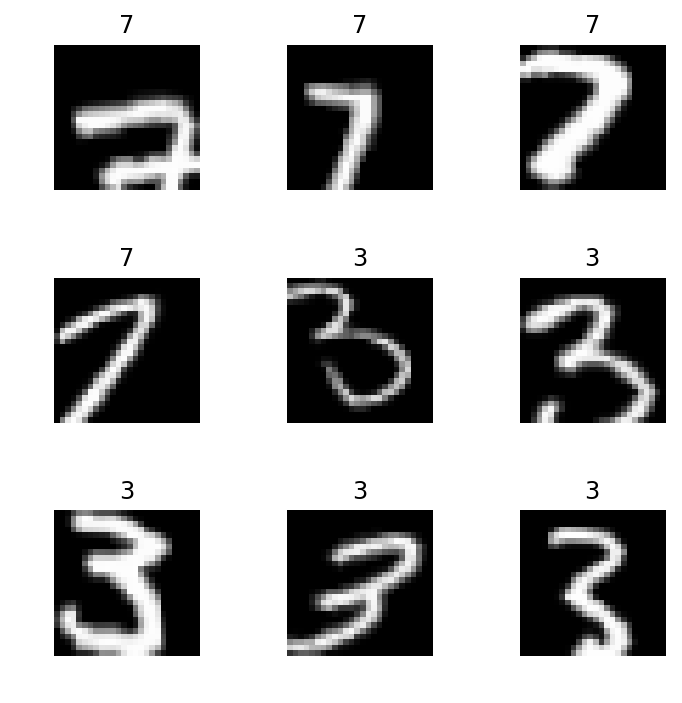

In [22]:
data.show_batch(rows=3, figsize=(5,5))

In [23]:
learn = ConvLearner(data, models.resnet18, metrics=accuracy)

In [26]:
learn.fit(2)

Total time: 00:13
epoch  train loss  valid loss  accuracy
1      0.124867    0.030495    0.989696  (00:06)
2      0.059256    0.015430    0.995093  (00:06)



#### Image data from a CSV file

In [24]:
df = pd.read_csv(path/'labels.csv')

In [25]:
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [27]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

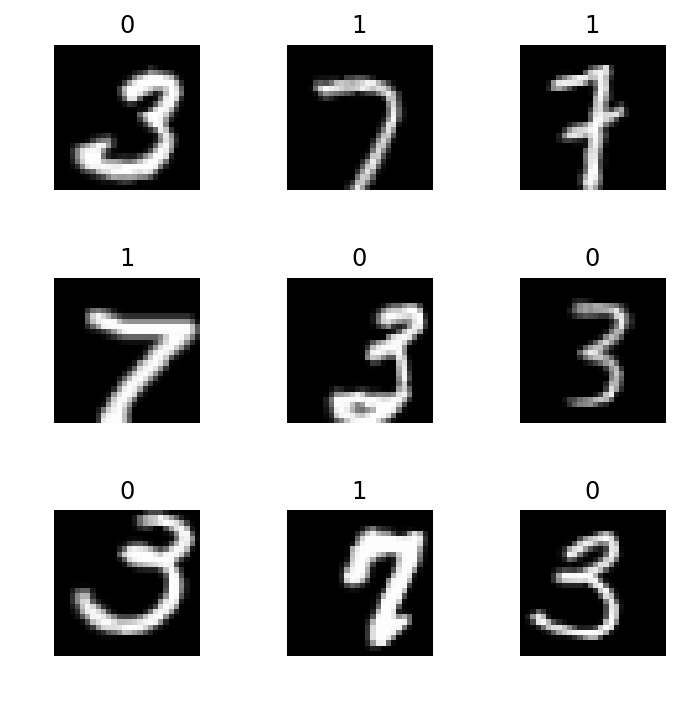

In [30]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

#### Image data from a dataframe

In [31]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

#### Image data from filenames

In [33]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/jupyter/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/jupyter/.fastai/data/mnist_sample/train/3/21102.png')]

In [34]:
pat = r'(\d)/\d+\.png$'
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

#### Image data from a name function

In [35]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24, 
            label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

#### Image data from a list

In [36]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [37]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']